<a href="https://colab.research.google.com/github/DrPaulaEkene/Uterine-Myoma-Uterine-fibroids-MRI-image-classification/blob/main/Uterine_Myoma_(Uterine_fibroids)_MRI_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook focuses on the Comparative Analysis of Deep Learning Architectures for Uterine Myoma Classification: Custom CNN vs. VGGNet-16 and ResNet50**

*Import all needed libraries*

In [1]:
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import the drive module
from google.colab import drive

# Mount the Google Drive to the specified mount point in the Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Create the data file paths/directories
import os
data_directory = "/content/drive/MyDrive/UMD"
print(os.listdir(data_directory))

['.DS_Store', 'UMD_221129_292', 'UMD_221129_293', 'UMD_221129_295', 'UMD_221129_294', 'UMD_221129_299', 'UMD_221129_298', 'UMD_221129_300', 'UMD_221129_296', 'UMD_221129_291', 'UMD_221129_297', 'UMD_221129_289', 'UMD_221129_282', 'UMD_221129_287', 'UMD_221129_288', 'UMD_221129_290', 'UMD_221129_286', 'UMD_221129_285', 'UMD_221129_283', 'UMD_221129_284', 'UMD_221129_281', 'UMD_221129_274', 'UMD_221129_276', 'UMD_221129_280', 'UMD_221129_271', 'UMD_221129_272', 'UMD_221129_275', 'UMD_221129_273', 'UMD_221129_279', 'UMD_221129_278', 'UMD_221129_277', 'UMD_221129_263', 'UMD_221129_268', 'UMD_221129_267', 'UMD_221129_270', 'UMD_221129_261', 'UMD_221129_269', 'UMD_221129_262', 'UMD_221129_266', 'UMD_221129_265', 'UMD_221129_264', 'UMD_221129_258', 'UMD_221129_254', 'UMD_221129_257', 'UMD_221129_252', 'UMD_221129_256', 'UMD_221129_260', 'UMD_221129_253', 'UMD_221129_255', 'UMD_221129_259', 'UMD_221129_251', 'UMD_221129_242', 'UMD_221129_243', 'UMD_221129_250', 'UMD_221129_247', 'UMD_221129_24

In [19]:
# List all contents of the directory
contents = os.listdir(data_directory)
print("Contents of the UMD dataset directory:", contents)

Contents of the UMD dataset directory: ['.DS_Store', 'UMD_221129_292', 'UMD_221129_293', 'UMD_221129_295', 'UMD_221129_294', 'UMD_221129_299', 'UMD_221129_298', 'UMD_221129_300', 'UMD_221129_296', 'UMD_221129_291', 'UMD_221129_297', 'UMD_221129_289', 'UMD_221129_282', 'UMD_221129_287', 'UMD_221129_288', 'UMD_221129_290', 'UMD_221129_286', 'UMD_221129_285', 'UMD_221129_283', 'UMD_221129_284', 'UMD_221129_281', 'UMD_221129_274', 'UMD_221129_276', 'UMD_221129_280', 'UMD_221129_271', 'UMD_221129_272', 'UMD_221129_275', 'UMD_221129_273', 'UMD_221129_279', 'UMD_221129_278', 'UMD_221129_277', 'UMD_221129_263', 'UMD_221129_268', 'UMD_221129_267', 'UMD_221129_270', 'UMD_221129_261', 'UMD_221129_269', 'UMD_221129_262', 'UMD_221129_266', 'UMD_221129_265', 'UMD_221129_264', 'UMD_221129_258', 'UMD_221129_254', 'UMD_221129_257', 'UMD_221129_252', 'UMD_221129_256', 'UMD_221129_260', 'UMD_221129_253', 'UMD_221129_255', 'UMD_221129_259', 'UMD_221129_251', 'UMD_221129_242', 'UMD_221129_243', 'UMD_221129

Instal pydicom Pillow to read dcm files

In [20]:
# install pydicom pillow
pip install pydicom Pillow

In [21]:
# Read and Convert all dcm images to jpg
import os
import pydicom
import numpy as np
from PIL import Image

# Function to convert DICOM to JPG
def dicom_to_jpg(dicom_file_path, output_file_path):
    try:
        # Read the DICOM file
        dicom = pydicom.dcmread(dicom_file_path)
        # Extract the image data as a NumPy array
        image = dicom.pixel_array

        # Normalize the image to the range [0, 255]
        image = (np.maximum(image, 0) / image.max()) * 255.0
        image = np.uint8(image)

        # Convert the NumPy array to a PIL Image
        pil_image = Image.fromarray(image)

        # Save the image as a JPG file
        pil_image.save(output_file_path)
        print(f"Saved {output_file_path}")
    except Exception as e:
        print(f"Failed to process {dicom_file_path}: {e}")

# Function to traverse the directory and convert DICOM files
def convert_dicom_directory(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for file_name in files:
            if file_name.endswith('.dcm'):
                dicom_file_path = os.path.join(root, file_name)
                relative_path = os.path.relpath(dicom_file_path, input_folder)
                output_file_path = os.path.join(output_folder, relative_path).replace('.dcm', '.jpg')

                # Create the output directory if it doesn't exist
                output_dir = os.path.dirname(output_file_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                dicom_to_jpg(dicom_file_path, output_file_path)

input_folder = data_directory
output_folder = os.path.join(os.getcwd(), 'output_jpg')

# Create the output directory
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

convert_dicom_directory(input_folder, output_folder)

Streaming output truncated to the last 5000 lines.
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_15.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_19.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_12.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_13.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_16.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_23.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_22.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_20.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_14.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_21.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_09.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_11.jpg
Saved /content/output_jpg/UMD_221129_211/UMD_221129_211_17.jpg
Saved /content/output_jpg/UMD_221129_212/UMD_221129_212_19.jpg
Saved /content/output_jpg/UMD_221129_212/UMD_221129_212_10.jpg
Save

In [16]:
import shutil
shutil.make_archive('/content/output_jpg', 'zip', '/content/output_jpg')
from google.colab import files
files.download('/content/output_jpg.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*Data Preparation*

Found 10 DICOM images. Displaying the first 10 images.


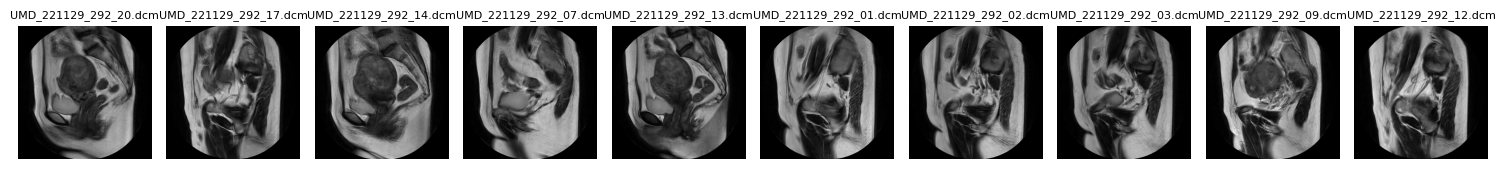

In [11]:
# Visualize the dcm images
import os
import matplotlib.pyplot as plt
import pydicom

# Path to the UMD dataset directory
data_directory = "/content/drive/MyDrive/UMD"

# Function to visualize DICOM images
def visualize_dicom_images(directory, num_images=10):
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                images.append(os.path.join(root, file))
                if len(images) >= num_images:
                    break
        if len(images) >= num_images:
            break

    if not images:
        print("No DICOM images found in the directory.")
        return

    print(f"Found {len(images)} DICOM images. Displaying the first {num_images} images.")

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, image_path in enumerate(images):
        try:
            ds = pydicom.dcmread(image_path)
            axes[i].imshow(ds.pixel_array, cmap='gray')
            axes[i].set_title(os.path.basename(image_path), fontsize=8)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading DICOM image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

# Visualize some DICOM images from the dataset
visualize_dicom_images(data_directory)


In [ ]:
# assign batch sizes, image height and width
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# data preparation with image generator